In [1]:
import numpy as np
import pandas as pd

In [2]:
import sys

In [3]:
from create_matrix import create_matrix_region_appliance_year

In [4]:
import pickle

In [5]:
knn_p = pickle.load(open("predictions/knn.pkl",'r'))
knn_oracle_p = pickle.load(open("predictions/knn_oracle.pkl",'r'))

ml_p = pickle.load(open("predictions/metric_knn.pkl",'r'))
mf_p = pickle.load(open("predictions/mf.pkl",'r'))

tensor_parafac_p = pickle.load(open("predictions/tensor-parafac.pkl",'r'))
tensor_custom_p = pickle.load(open("predictions/tensor-custom.pkl",'r'))
tensor_custom_p_rel = pickle.load(open("predictions/tensor-custom-relative.pkl",'r'))

tensor_custom_parafac_static_p = pickle.load(open("predictions/tensor-custom-parafac-static-abs.pkl",'r'))
tensor_custom_parafac_static_rel_p = pickle.load(open("predictions/tensor-custom-parafac-static-rel.pkl",'r'))

tensor_custom_case_2_static_weather_rel_p = pickle.load(open("predictions/tensor-custom-2-static-weather-rel.pkl",'r'))
tensor_custom_case_2_static_weather_abs_p = pickle.load(open("predictions/tensor-custom-2-static-weather-abs.pkl",'r'))
tensor_custom_case_2_static_abs_p = pickle.load(open("predictions/tensor-custom-2-static-abs.pkl",'r'))
tensor_custom_case_2_static_rel_p = pickle.load(open("predictions/tensor-custom-2-static-rel.pkl",'r'))

In [6]:
thresholds = {'fridge':10,'hvac':100,'dw':0.5,'mw':0.5,'oven':0.5,'wm':0.5}

In [7]:
from create_matrix import *
from sklearn.metrics import  mean_squared_error
def compute_rmse_fraction(appliance, pred_df, region='Austin',year=2014):
    appliance_df = create_matrix_region_appliance_year(region, year, appliance)

    if appliance == "hvac":
        start, stop = 5, 11
    else:
        start, stop = 1, 13
    pred_df = pred_df.copy()
    pred_df.columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
    gt_df = appliance_df[pred_df.columns].ix[pred_df.index]
    
    if appliance in thresholds:
        a = gt_df[gt_df<thresholds[appliance]].sum(axis=1)
        homes_ignore = a[a>0].index
        gt_df_index = [x for x in gt_df.index if x not in homes_ignore]
        gt_df = gt_df.ix[gt_df_index]
    

    aggregate_df = appliance_df.ix[pred_df.index][['aggregate_%d' % month for month in range(start, stop)]]

    aggregate_df.columns = gt_df.columns
    rows, cols = np.where((aggregate_df < 300))
    for r, c in zip(rows, cols):
        r_i, c_i = aggregate_df.index[r], aggregate_df.columns[c]
        aggregate_df.loc[r_i, c_i] = np.NaN

    gt_fraction = gt_df.div(aggregate_df) * 100
    pred_fraction = pred_df.div(aggregate_df) * 100

    gt_fraction_dropna = gt_fraction.unstack().dropna()
    pred_fraction_dropna = pred_fraction.unstack().dropna()
    index_intersection = gt_fraction_dropna.index.intersection(pred_fraction_dropna.index)
    gt_fraction_dropna = gt_fraction_dropna.ix[index_intersection]
    pred_fraction_dropna = pred_fraction_dropna.ix[index_intersection]
    difference_error = (gt_fraction_dropna-pred_fraction_dropna).abs()

    rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
    return gt_fraction_dropna, pred_fraction_dropna, rms, difference_error


In [8]:
gt_f, pred_f, rms, e = compute_rmse_fraction('hvac',knn_p['hvac']['energy'][1])

In [9]:
tf_custom= {}
for appliance in tensor_custom_p:
    tf_custom[appliance]= {}
    for case in range(1, 5):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance,tensor_custom_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom[appliance][case] = best_error

In [10]:
pd.DataFrame(tf_custom)

,dw,fridge,hvac,mw,oven,wm
1,1.015313,3.366433,11.241343,1.973878,1.284930,0.410792
2,1.044611,3.467128,10.646634,2.002549,1.335421,0.427745
3,0.945728,3.269449,13.843434,1.935640,1.298701,0.427746
4,1.021321,3.372943,12.855545,1.920763,1.224413,0.420098


In [11]:
pd.DataFrame(tf_custom)

,dw,fridge,hvac,mw,oven,wm
1,1.015313,3.366433,11.241343,1.973878,1.284930,0.410792
2,1.044611,3.467128,10.646634,2.002549,1.335421,0.427745
3,0.945728,3.269449,13.843434,1.935640,1.298701,0.427746
4,1.021321,3.372943,12.855545,1.920763,1.224413,0.420098


In [12]:
tf_custom_rel= {}
for appliance in tensor_custom_p_rel:
    tf_custom_rel[appliance]= {}
    for case in range(1, 5):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance,tensor_custom_p_rel[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_rel[appliance][case] = best_error

In [13]:
pd.DataFrame(tf_custom_rel)

,dw,fridge,hvac,mw,oven,wm
1,1.095330,3.557678,11.892557,2.025017,1.397890,0.435945
2,0.995240,3.138089,11.143609,2.019163,1.331407,0.434767
3,1.101451,3.279699,13.424384,2.016284,1.368528,0.428746
4,1.062122,3.153939,13.268355,1.982499,1.239504,0.398593


# TF-Custom Parafac with static

In [14]:
tf_custom_parafac_static = {}
for appliance in tensor_custom_parafac_static_p:
    tf_custom_parafac_static[appliance]= {}
    for case in range(4, 5):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_parafac_static_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_parafac_static[appliance] = best_error

In [15]:
tf_custom_parafac_static

{'dw': 0.90813484231798647,
 'fridge': 3.1111082414824276,
 'hvac': 14.688244407623495,
 'mw': 1.9814217861536105,
 'oven': 1.3082850243745403,
 'wm': 0.40956133691606295}

In [16]:
tf_custom_parafac_static_rel = {}
for appliance in tensor_custom_parafac_static_rel_p:
    tf_custom_parafac_static_rel[appliance]= {}
    for case in range(4, 5):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_parafac_static_rel_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_parafac_static_rel[appliance] = best_error

In [17]:
tf_custom_parafac_static_rel

{'dw': 0.90285495234443891,
 'fridge': 3.1014313093702497,
 'hvac': 14.739587681161389,
 'mw': 1.9439690571800599,
 'oven': 1.2545870810872157,
 'wm': 0.41716058138375756}

### TF case 2 with static and weather

In [18]:
tf_custom_2_static_weather = {}
for appliance in tensor_custom_case_2_static_weather_rel_p:
    tf_custom_2_static_weather[appliance]= {}
    for case in range(2, 3):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_case_2_static_weather_rel_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_2_static_weather[appliance] = best_error

In [19]:
tf_custom_2_static_weather

{'dw': 0.79745046375952278,
 'fridge': 3.2268442696823505,
 'hvac': 14.234729939005565,
 'mw': 1.9542634670641397,
 'oven': 1.2005492932880975,
 'wm': 0.40795521196320578}

In [20]:
tf_custom_2_static_weather_abs = {}
for appliance in tensor_custom_case_2_static_weather_abs_p:
    tf_custom_2_static_weather_abs[appliance]= {}
    for case in range(2, 3):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_case_2_static_weather_abs_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_2_static_weather_abs[appliance] = best_error

In [21]:
tf_custom_2_static_weather_abs

{'dw': 0.78513664117370596,
 'fridge': 3.2314853095574265,
 'hvac': 14.649122620059849,
 'mw': 1.9528030386742821,
 'oven': 1.1968301744910335,
 'wm': 0.40834149486554694}

In [22]:
tf_custom_2_static_abs = {}
for appliance in tensor_custom_case_2_static_abs_p:
    tf_custom_2_static_abs[appliance]= {}
    for case in range(2, 3):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_case_2_static_abs_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_2_static_abs[appliance] = best_error

In [23]:
tf_custom_2_static_abs

{'dw': 0.88753002233648781,
 'fridge': 3.1727429101042084,
 'hvac': 13.999235675636662,
 'mw': 1.9991296654247779,
 'oven': 1.2658658575316553,
 'wm': 0.4170391955111149}

In [24]:
tf_custom_2_static_rel = {}
for appliance in tensor_custom_case_2_static_rel_p:
    tf_custom_2_static_rel[appliance]= {}
    for case in range(2, 3):
        best_error = 1e6
        for a in range(1, 6):
            alpha, beta, error, e = compute_rmse_fraction(appliance, tensor_custom_case_2_static_rel_p[appliance][case][a])
            if error < best_error:
                best_error = error
                tf_custom_2_static_rel[appliance] = best_error

In [25]:
tf_custom_2_static_rel

{'dw': 0.88769964028353676,
 'fridge': 3.1990933545141935,
 'hvac': 14.3246447362641,
 'mw': 1.9828217844199387,
 'oven': 1.2519380588536593,
 'wm': 0.42473769693916652}

In [26]:
knn_oracle = {}
for appliance in knn_oracle_p:
    a, b, knn_oracle[appliance], e = compute_rmse_fraction(appliance, knn_oracle_p[appliance])

In [27]:
pd.Series(knn_oracle)

dw        0.408863
fridge    1.188430
hvac      4.982974
mw        1.348498
oven      0.763501
wm        0.265638
dtype: float64

In [28]:
knn_results = {}
for appliance in knn_p:
    knn_results[appliance] = {}
    for feature in ['energy_static','energy']:
        knn_results[appliance][feature] = 1000
        least_error = 1000
        best_n = None
        for neighbours in range(1, 10):
            pred = knn_p[appliance][feature][neighbours]
            gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)
            if rms < least_error:
                least_error = rms
                best_n = neighbours
        knn_results[appliance][feature] = least_error

In [29]:
pd.DataFrame(knn_results)

,dw,fridge,hvac,mw,oven,wm
energy,0.929514,3.126479,10.465394,1.993444,1.154153,0.405615
energy_static,0.817954,3.172089,10.558696,2.089268,1.162794,0.423217


In [30]:
ml_results = {}
for appliance in ml_p:
    ml_results[appliance] = {}
    for feature in ['energy_static','energy']:
        ml_results[appliance][feature] = 1000
        least_error = 1000
        best_n = None
        for neighbours in range(1, 10):
            pred = ml_p[appliance][feature][neighbours]
            gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)
            if rms < least_error:
                least_error = rms
                best_n = neighbours
        ml_results[appliance][feature] = least_error

In [31]:
pd.DataFrame(ml_results)

,dw,fridge,hvac,mw,oven,wm
energy,0.936958,3.120817,10.436645,1.895130,1.154415,0.401950
energy_static,0.915690,3.089264,10.580676,1.975535,1.155719,0.403097


In [32]:
pd.DataFrame(ml_results)

,dw,fridge,hvac,mw,oven,wm
energy,0.936958,3.120817,10.436645,1.895130,1.154415,0.401950
energy_static,0.915690,3.089264,10.580676,1.975535,1.155719,0.403097


In [33]:
mf_results = {}
for appliance in mf_p:
    mf_results[appliance] = {}
    for feature in ['energy_static','energy']:
        mf_results[appliance][feature] = {}
        for cost in ['relative','absolute']:
            mf_results[appliance][feature][cost] = {}
            least_error = 1000
            for lat in range(3, 8):
                print lat, cost, feature, appliance
                pred = mf_p[appliance][feature][cost][lat]
                gt_f, pred_f, rms,e  = compute_rmse_fraction(appliance, pred)
                if rms < least_error:
                    least_error = rms
                    best_k = lat
                    print best_k, least_error
            mf_results[appliance][feature][cost] = least_error

3 relative energy_static hvac
3 22.655741394
4 relative energy_static hvac
4 13.5403540668
5 relative energy_static hvac
6 relative energy_static hvac
7 relative energy_static hvac
3 absolute energy_static hvac
3 14.5771709799
4 absolute energy_static hvac
4 10.8156606845
5 absolute energy_static hvac
6 absolute energy_static hvac
7 absolute energy_static hvac
3 relative energy hvac
3 19.0874740212
4 relative energy hvac
4 18.838639112
5 relative energy hvac
5 14.2304715984
6 relative energy hvac
7 relative energy hvac
3 absolute energy hvac
3 17.9768370113
4 absolute energy hvac
4 17.9498297022
5 absolute energy hvac
5 17.0063150041
6 absolute energy hvac
6 15.8978949217
7 absolute energy hvac
7 12.9552506787
3 relative energy_static wm
3 0.41942818879
4 relative energy_static wm
5 relative energy_static wm
6 relative energy_static wm
7 relative energy_static wm
3 absolute energy_static wm
3 0.401352668519
4 absolute energy_static wm
5 absolute energy_static wm
6 absolute energy_stati

In [34]:
mf_relative = {}
mf_abs = {}
for appliance in mf_results.keys():
    for cost in ['relative','absolute']:
        if cost=="absolute":
            mf_abs[appliance] =  pd.DataFrame(mf_results[appliance]).ix[cost]
        else:
            mf_relative[appliance] =  pd.DataFrame(mf_results[appliance]).ix[cost]


In [35]:
pd.DataFrame(mf_relative)

,dw,fridge,hvac,mw,oven,wm
energy,1.359751,4.139814,14.230472,1.993616,1.388691,0.433638
energy_static,0.911166,3.667358,13.540354,2.055984,1.282576,0.419428


In [36]:
pd.DataFrame(mf_abs)

,dw,fridge,hvac,mw,oven,wm
energy,0.997866,3.383999,12.955251,1.956887,1.158239,0.413536
energy_static,0.779768,3.087220,10.815661,1.952947,1.196253,0.401353


In [37]:
tensor_parafac_results = {}
for appliance in tensor_parafac_p:
    tensor_parafac_results[appliance] = {}
    least_error = 1000
    best_n = None
    for neighbours in range(1, 7):
        pred = tensor_parafac_p[appliance][neighbours]
        gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)
        if rms < least_error:
            least_error = rms
            best_n = neighbours
    tensor_parafac_results[appliance] = least_error

In [38]:
tensor_parafac_results

{'dw': 1.1738346178819563,
 'fridge': 4.9800162340159719,
 'hvac': 13.062402826718396,
 'mw': 2.0478110262537661,
 'oven': 1.4450339975234432,
 'wm': 0.47913131405530257}

In [39]:
from scipy.io import loadmat
tl_res = {}
tensor_lab_data = loadmat('predictions/tl_small.mat')
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    pred = pd.DataFrame(tensor_lab_data['out'][0, 0][appliance])
    gt_df = create_matrix_region_appliance_year('Austin', 2014, appliance, all_features=True)
    pred.index = gt_df.index
    gt_f, pred_f, tl_res[appliance],e  = compute_rmse_fraction(appliance, pred)

In [40]:
tl_res

{'dw': 1.0736181213643905,
 'fridge': 4.5731599893555588,
 'hvac': 32.242131953001731,
 'mw': 1.9732709171436775,
 'oven': 1.1904740167936398,
 'wm': 0.44832544541107211}

In [41]:
from scipy.io import loadmat
tl_res_non_neg = {}
tensor_lab_data = loadmat('predictions/tl_small_non_negative.mat')
for appliance in ['fridge','hvac','dw','mw','wm','oven']:
    pred = pd.DataFrame(tensor_lab_data['out'][0, 0][appliance])
    gt_df = create_matrix_region_appliance_year('Austin', 2014, appliance, all_features=True)
    pred.index = gt_df.index
    gt_f, pred_f, tl_res_non_neg[appliance],e  = compute_rmse_fraction(appliance, pred)

In [42]:
tl_res_non_neg

{'dw': 1.2188392623989799,
 'fridge': 5.2866421980527019,
 'hvac': 14.275227081312478,
 'mw': 2.0780385039850997,
 'oven': 1.4598670955926984,
 'wm': 0.49626342649243005}

In [43]:
results_df ={}
results_df[('MF (Abs)','Energy')] = pd.DataFrame(mf_abs).ix['energy']
results_df[('MF (Abs)','Energy+Static')] = pd.DataFrame(mf_abs).ix['energy_static']

results_df[('MF (Rel)','Energy')] = pd.DataFrame(mf_relative).ix['energy']
results_df[('MF (Rel)','Energy+Static')] = pd.DataFrame(mf_relative).ix['energy_static']

results_df[('Tensor (Parafac)\n [Out of tensor] ','Energy')] = pd.Series(tensor_parafac_results)
results_df[('Tensor (Parafac)\n [In tensor] ','Energy')] = pd.Series(tl_res)
results_df[('Tensor (Parafac)\n [In tensor (Non-negative)] ','Energy')] = pd.Series(tl_res_non_neg)




results_df[('KNN','Energy')] = pd.DataFrame(knn_results).ix['energy']
results_df[('KNN','Energy+Static')] = pd.DataFrame(knn_results).ix['energy_static']
#results_df[('KNN','Oracle')] = pd.Series(knn_oracle)

results_df[('KNN (ML)','Energy')] = pd.DataFrame(ml_results).ix['energy']
results_df[('KNN (ML)','Energy+Static')] = pd.DataFrame(ml_results).ix['energy_static']

for case in range(1, 5):
    results_df[('TF-Custom-'+str(case)+" (Abs)",'Energy')] = pd.DataFrame(tf_custom).ix[case]

for case in range(1, 5):
    results_df[('TF-Custom-'+str(case)+" (Rel)",'Energy')] = pd.DataFrame(tf_custom_rel).ix[case]

results_df[('TF-Custom-'+str(4)+" (Abs)",'Energy+Static')] = pd.Series(tf_custom_parafac_static)
results_df[('TF-Custom-'+str(4)+" (Rel)",'Energy+Static')] = pd.Series(tf_custom_parafac_static_rel)

results_df[('TF-Custom-'+str(2)+" (Rel)",'Energy+Static+Weather')] = pd.Series(tf_custom_2_static_weather)
results_df[('TF-Custom-'+str(2)+" (Abs)",'Energy+Static+Weather')] = pd.Series(tf_custom_2_static_weather_abs)
results_df[('TF-Custom-'+str(2)+" (Abs)",'Energy+Static')] = pd.Series(tf_custom_2_static_abs)
results_df[('TF-Custom-'+str(2)+" (Rel)",'Energy+Static')] = pd.Series(tf_custom_2_static_rel)








In [44]:
pd.DataFrame(results_df)

KNN                 KNN (ML)                 MF (Abs)  \
           Energy Energy+Static     Energy Energy+Static     Energy   
dw       0.929514      0.817954   0.936958      0.915690   0.997866   
fridge   3.126479      3.172089   3.120817      3.089264   3.383999   
hvac    10.465394     10.558696  10.436645     10.580676  12.955251   
mw       1.993444      2.089268   1.895130      1.975535   1.956887   
oven     1.154153      1.162794   1.154415      1.155719   1.158239   
wm       0.405615      0.423217   0.401950      0.403097   0.413536   

                       MF (Rel)               TF-Custom-1 (Abs)  \
       Energy+Static     Energy Energy+Static            Energy   
dw          0.779768   1.359751      0.911166          1.015313   
fridge      3.087220   4.139814      3.667358          3.366433   
hvac       10.815661  14.230472     13.540354         11.241343   
mw          1.952947   1.993616      2.055984          1.973878   
oven        1.196253   1.388691      1.282576          1.284930   
wm          0.401353   0.433638      0.419428          0.410792   

       TF-Custom-1 (Rel)                 ...                  \
                  Energy                 ...                   
dw              1.095330                 ...                   
fridge          3.557678                 ...                   
hvac           11.892557                 ...                   
mw              2.025017                 ...                   
oven            1.397890                 ...                   
wm              0.435945                 ...                   

           TF-Custom-2 (Rel) TF-Custom-3 (Abs) TF-Custom-3 (Rel)  \
       Energy+Static+Weather            Energy            Energy   
dw                  0.797450          0.945728          1.101451   
fridge              3.226844          3.269449          3.279699   
hvac               14.234730         13.843434         13.424384   
mw                  1.954263          1.935640          2.016284   
oven                1.200549          1.298701          1.368528   
wm                  0.407955          0.427746          0.428746   

       TF-Custom-4 (Abs)               TF-Custom-4 (Rel)                \
                  Energy Energy+Static            Energy Energy+Static   
dw              1.021321      0.908135          1.062122      0.902855   
fridge          3.372943      3.111108          3.153939      3.101431   
hvac           12.855545     14.688244         13.268355     14.739588   
mw              1.920763      1.981422          1.982499      1.943969   
oven            1.224413      1.308285          1.239504      1.254587   
wm              0.420098      0.409561          0.398593      0.417161   

       Tensor (Parafac)\n [In tensor (Non-negative)]   \
                                               Energy   
dw                                           1.218839   
fridge                                       5.286642   
hvac                                        14.275227   
mw                                           2.078039   
oven                                         1.459867   
wm                                           0.496263   

       Tensor (Parafac)\n [In tensor]  Tensor (Parafac)\n [Out of tensor]   
                                Energy                              Energy  
dw                            1.073618                            1.173835  
fridge                        4.573160                            4.980016  
hvac                         32.242132                           13.062403  
mw                            1.973271                            2.047811  
oven                          1.190474                            1.445034  
wm                            0.448325                            0.479131  

[6 rows x 25 columns]

In [45]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: gray' if v else '' for v in is_min]

In [46]:
pd.set_option('precision', 3)
out = pd.DataFrame(results_df).T
out.columns = [str.capitalize(x) for x in out.columns]
import seaborn as sns

cm = sns.light_palette("orange", as_cmap=True)

s = out.style.background_gradient(cmap=cm)
s
#out.style.apply(highlight_min)
#out.style.set_properties(**{'text-align': 'right'})


In [47]:
out

Dw  \
KNN                                            Energy                 0.930   
                                               Energy+Static          0.818   
KNN (ML)                                       Energy                 0.937   
                                               Energy+Static          0.916   
MF (Abs)                                       Energy                 0.998   
                                               Energy+Static          0.780   
MF (Rel)                                       Energy                 1.360   
                                               Energy+Static          0.911   
TF-Custom-1 (Abs)                              Energy                 1.015   
TF-Custom-1 (Rel)                              Energy                 1.095   
TF-Custom-2 (Abs)                              Energy                 1.045   
                                               Energy+Static          0.888   
                                               Energy+Static+Weather  0.785   
TF-Custom-2 (Rel)                              Energy                 0.995   
                                               Energy+Static          0.888   
                                               Energy+Static+Weather  0.797   
TF-Custom-3 (Abs)                              Energy                 0.946   
TF-Custom-3 (Rel)                              Energy                 1.101   
TF-Custom-4 (Abs)                              Energy                 1.021   
                                               Energy+Static          0.908   
TF-Custom-4 (Rel)                              Energy                 1.062   
                                               Energy+Static          0.903   
Tensor (Parafac)\n [In tensor (Non-negative)]  Energy                 1.219   
Tensor (Parafac)\n [In tensor]                 Energy                 1.074   
Tensor (Parafac)\n [Out of tensor]             Energy                 1.174   

                                                                      Fridge  \
KNN                                            Energy                  3.126   
                                               Energy+Static           3.172   
KNN (ML)                                       Energy                  3.121   
                                               Energy+Static           3.089   
MF (Abs)                                       Energy                  3.384   
                                               Energy+Static           3.087   
MF (Rel)                                       Energy                  4.140   
                                               Energy+Static           3.667   
TF-Custom-1 (Abs)                              Energy                  3.366   
TF-Custom-1 (Rel)                              Energy                  3.558   
TF-Custom-2 (Abs)                              Energy                  3.467   
                                               Energy+Static           3.173   
                                               Energy+Static+Weather   3.231   
TF-Custom-2 (Rel)                              Energy                  3.138   
                                               Energy+Static           3.199   
                                               Energy+Static+Weather   3.227   
TF-Custom-3 (Abs)                              Energy                  3.269   
TF-Custom-3 (Rel)                              Energy                  3.280   
TF-Custom-4 (Abs)                              Energy                  3.373   
                                               Energy+Static           3.111   
TF-Custom-4 (Rel)                              Energy                  3.154   
                                               Energy+Static           3.101   
Tensor (Parafac)\n [In tensor (Non-negative)]  Energy                  5.287   
Tensor (Parafac)\n [In tensor]                 Energy                  4.573   
Tensor (Parafac)\n

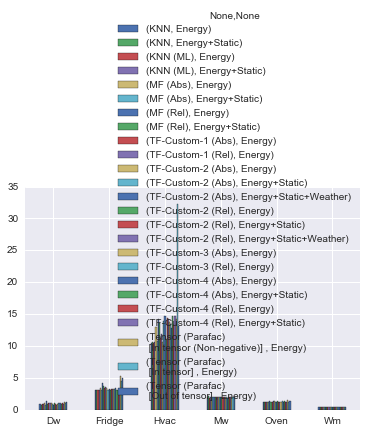

In [48]:
%matplotlib inline
out.T.plot(kind="bar",rot=0)

In [49]:
appliance='hvac'
pred = knn_p[appliance][feature][neighbours]
gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)

In [50]:
print neighbours
pred = mf_p[appliance][feature]['relative'][neighbours]
gt_f, pred_f, rms, e = compute_rmse_fraction(appliance, pred)

6


In [51]:
e[e>50]

hvac_8  5109    162.12
dtype: float64

In [52]:
pred.ix[7641]

KeyError: 7641

In [ ]:
gt_f.ix[7641]

In [ ]:
pred_f[pred_f>60].unstack().dropna()

In [ ]:
from mf_core import *

import numpy as np
import pandas as pd
import sys
from create_matrix import *
from sklearn.model_selection import LeaveOneOut
from scipy.optimize import nnls

import pickle
from tensor_custom_core import *


APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

def un_normalize(x, maximum, minimum):
    return (maximum-minimum)*x + minimum


a, b = 3, 3

print a, b


pred = {}
for appliance in APPLIANCES[:1]:
    pred[appliance] = {}
    if appliance == "hvac":
        start, stop = 5, 11
    else:
        start, stop = 1, 13
    months = stop - start
    pred[appliance] = {}
    appliance_df = create_matrix_all_entries(region, year, appliance)
    aggregate_cols = [x for x in appliance_df.columns if "aggregate" in x]
    appliance_cols = [x for x in appliance_df.columns if appliance in x]
    energy_cols = np.concatenate([aggregate_cols, appliance_cols])

    df = appliance_df.copy()

In [ ]:
df.columns[-3:]

In [ ]:
static_cols = ['area', 'total_occupants', 'num_rooms']
static_df = df[static_cols]
static_df = static_df.div(static_df.max())

In [ ]:
static_df

In [ ]:
weather_df = np.ones(len(static_df)).reshape(-1, 1)

In [ ]:
weather_df